<a href="https://colab.research.google.com/github/sulphatet/transfer_learning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook demonstrates transfer learning and the effect freezing layers of the pretrained model brings to overall accuracy of the resulting model. We finetune to model on the Flowers dataset.

### Importing the data and libraraies:

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import pandas as pd
from torch import nn
import numpy as np
from PIL import Image
from PIL import ImageFile
from torchvision.models import resnet50
from torchinfo import summary
import matplotlib.pyplot as plt
import torchvision.transforms as T
import random
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [3]:
device = 'cuda'
device

'cuda'

In [4]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz"
download_url(dataset_url, '.')
with tarfile.open('/content/oxford-102-flowers.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

  0%|          | 0/345236087 [00:00<?, ?it/s]

The dataset has labels in a txtfile, for convenience, we convert them into a csv file. The data is already split into training, validation and testing sets, and does not require class mapping.

In [5]:
def make_csv(filename, csvname):
  """ Helper function to convert .txt to legible csv format
  """
  Z = []
  with open('/content/data/oxford-102-flowers/' + filename + '.txt') as file:
      for line in file:
          X = line.split(' ')
          Z.append([X[0],int(X[1])])
  data = pd.DataFrame(Z,columns = ('imgID','label'))
  print(len(Z))
  data.to_csv('/content/data/oxford-102-flowers/' + csvname + '.csv')

In [6]:
M = ['test','train','valid']
N = ['train','test','valid']

for i in range(len(M)):
  make_csv(M[i],N[i])

6149
1020
1020


##### NOTE: We use the dataset with the largest number of samples (6149) as out training dataset, as hyperparameter tuning is not the purpose of the notebook, we ignore the validation dataset.

### Creating a dataloader, visualzing the data

The dataset consists of 102 categories of flowers, with each class having anywhere between 40 and 258 images. Before using a dataloader, we convert the data into a form which is easier to be loaded.

In [7]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

class ClassificationDataset:
    def __init__(self,image_path,targets,resize = None):
        self.image_path = image_path
        self.targets = targets
        self.resize = resize
    
    def __len__(self):
        return len(self.image_path)
        
    def __getitem__(self,item):
        image = Image.open(self.image_path[item])
        image = image.convert('RGB')
        targets = self.targets[item]
        
        if self.resize is not None:
            image = image.resize(
                (self.resize[1],self.resize[0]),
                resample = Image.BILINEAR
            )
        
        image = np.array(image)
            
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        
        return {
            'image' : torch.tensor(image,dtype= torch.float),
            'targets' : torch.tensor(targets,dtype = torch.long)
        }

In [8]:
data_path = '/content/data/oxford-102-flowers'

def make_datset(csvpath):
  """ Accepts a csv file of labels and corresponding images. 
  Returns: An object of ClassificationDataset Class.
  """
  df = pd.read_csv(csvpath)
  images = df.imgID.values.tolist()
  images = [
      os.path.join(data_path,i) for i in images
  ]
  class_nums = len(df['label'].unique())
  targets = df.label.values
  print(f'Number of images: {len(images)}')
  print(f'Number of targets: {targets.size}')
  print(f'Number of classes: {class_nums}')
  dataset = ClassificationDataset(image_path = images, targets = targets, resize = (224,224))
  return dataset


In [9]:
train_dataset = make_datset('/content/data/oxford-102-flowers/train.csv')

Number of images: 6149
Number of targets: 6149
Number of classes: 102


In [10]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = 64, shuffle = True
)

In [11]:
M = next(iter(train_loader))
print(M['image'].shape)
print(M['targets'].shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


Vizualizing some of the data: 

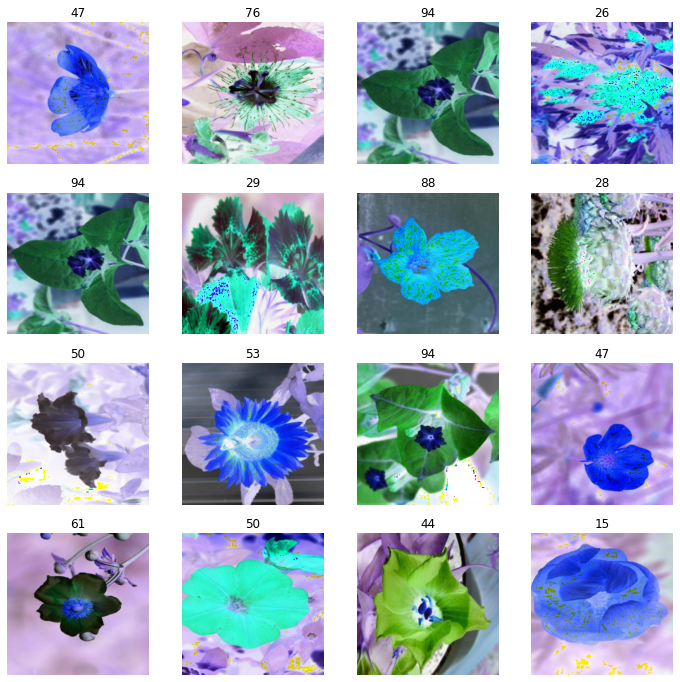

In [12]:
inputs, target = M['image'], M['targets']
fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, 63, size=[1]).item()
    img, label = inputs[random_idx],target[random_idx]
    fig.add_subplot(rows, cols, i)
    out = img.numpy().transpose((2,1,0))
    plt.imshow((out*255).astype(np.uint8),cmap = 'brg')
    plt.title(label.item())
    plt.axis(False);

In [13]:
test_dataset = make_datset('/content/data/oxford-102-flowers/valid.csv')
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 64, shuffle = True
)

Number of images: 1020
Number of targets: 1020
Number of classes: 102


### Defining the Models:
The main aim of this notebook is to note the performance of a pretrained model with its layers frozen, vs without its layers frozen. So we create two models and run them on our prepared data.

In [14]:
resnet_model = resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT).to(device)
for name, param in resnet_model.named_parameters() :
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
frozen_model = nn.Sequential(
    resnet_model,
    nn.Linear(in_features = 1000, out_features = 102)
).to(device)

In [16]:
summary(model=frozen_model, 
        input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [64, 102]                 --
├─ResNet: 1-1                                 [64, 1000]                --
│    └─Conv2d: 2-1                            [64, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [64, 64, 56, 56]          --
│    └─Sequential: 2-5                        [64, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [64, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [64, 256, 56, 56]         (70,400)
│    │    └─Bottleneck: 3-3                   [64, 256, 56, 56]         (70,400)
│    └─Sequential: 2-6                        [64, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [64, 512, 28, 28]      

In [17]:
# For training, we use the cross entropy loss function and the Adam optimizer:

optimizer = torch.optim.Adam(frozen_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)

#### We use the following helper functions to help tune our model parameters during training:

In [18]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.
    Returns:
    A tuple of training loss and training accuracy metrics.
    """
    model.train()

    train_loss, train_acc = 0, 0

    for batch, data in enumerate(dataloader):
        X = data['image']
        y = data['targets']

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) #returns accuracy
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.
    Returns:
    A tuple of testing loss and testing accuracy metrics.
    """
    model.eval() #set model in eval

    test_loss, test_acc = 0, 0

    with torch.inference_mode(): #works similar to torch.no_grad()
        for batch, data in enumerate(dataloader):
            X = data['image']
            y = data['targets']
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Uses the functiones perviously defined to train the PyTorch Model.
    Returns:
    Dictionary of results for each epoch.
    """
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # print results
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

We only concider the initial few epochs in this notebook. Thus, number of epochs is limited to 7. We use a batch-size of 64

In [19]:
results_frozen = train(model= frozen_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=7,
                       device=device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7837 | train_acc: 0.5272 | test_loss: 2.0894 | test_acc: 0.6365
Epoch: 2 | train_loss: 1.1729 | train_acc: 0.8222 | test_loss: 1.3251 | test_acc: 0.7774
Epoch: 3 | train_loss: 0.7266 | train_acc: 0.8968 | test_loss: 1.0282 | test_acc: 0.8276
Epoch: 4 | train_loss: 0.5151 | train_acc: 0.9351 | test_loss: 0.8868 | test_acc: 0.8525
Epoch: 5 | train_loss: 0.3840 | train_acc: 0.9533 | test_loss: 0.7715 | test_acc: 0.8654
Epoch: 6 | train_loss: 0.3039 | train_acc: 0.9664 | test_loss: 0.7090 | test_acc: 0.8776
Epoch: 7 | train_loss: 0.2483 | train_acc: 0.9781 | test_loss: 0.7061 | test_acc: 0.8793


#### We now create a model without freezing the layers of the resnet50

In [20]:
resnet_model2 = resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT).to(device)
for name, param in resnet_model2.named_parameters() :
    param.requires_grad = True

In [21]:
unfrozen_model = nn.Sequential(
    resnet_model2,
    nn.Linear(in_features = 1000, out_features = 102)
).to(device)

In [22]:
optimizer = torch.optim.Adam(unfrozen_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)

In [23]:
results_unfrozen = train(model= unfrozen_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=7,
                       device=device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1389 | train_acc: 0.7310 | test_loss: 1.0012 | test_acc: 0.7552
Epoch: 2 | train_loss: 0.2920 | train_acc: 0.9224 | test_loss: 0.7314 | test_acc: 0.8332
Epoch: 3 | train_loss: 0.1518 | train_acc: 0.9586 | test_loss: 0.3787 | test_acc: 0.9109
Epoch: 4 | train_loss: 0.1146 | train_acc: 0.9681 | test_loss: 0.6154 | test_acc: 0.8706
Epoch: 5 | train_loss: 0.1053 | train_acc: 0.9716 | test_loss: 1.3541 | test_acc: 0.8413
Epoch: 6 | train_loss: 0.1742 | train_acc: 0.9539 | test_loss: 0.7009 | test_acc: 0.8383
Epoch: 7 | train_loss: 0.1093 | train_acc: 0.9686 | test_loss: 0.5275 | test_acc: 0.8540


#### Finally, we freeze only the last few layers of a resnet50 model:

In [24]:
resnet_model3 = resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT).to(device)

for name, param in resnet_model3.named_parameters() :
    param.requires_grad = False
    #print(name)
    if name.startswith('layer4') or name.startswith('fc'): 
        param.requires_grad = True
        #print(name)

In [25]:
partial_model = nn.Sequential(
    resnet_model3,
    nn.Linear(in_features = 1000, out_features = 102)
).to(device)

In [26]:
optimizer = torch.optim.Adam(partial_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
results_partial = train(model= partial_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=7,
                       device=device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9415 | train_acc: 0.7893 | test_loss: 0.3761 | test_acc: 0.8980
Epoch: 2 | train_loss: 0.1101 | train_acc: 0.9718 | test_loss: 0.3007 | test_acc: 0.9333
Epoch: 3 | train_loss: 0.0504 | train_acc: 0.9865 | test_loss: 0.2597 | test_acc: 0.9489
Epoch: 4 | train_loss: 0.0552 | train_acc: 0.9851 | test_loss: 0.2552 | test_acc: 0.9471
Epoch: 5 | train_loss: 0.0423 | train_acc: 0.9884 | test_loss: 0.2699 | test_acc: 0.9481
Epoch: 6 | train_loss: 0.0313 | train_acc: 0.9936 | test_loss: 0.3103 | test_acc: 0.9539
Epoch: 7 | train_loss: 0.0171 | train_acc: 0.9968 | test_loss: 0.3808 | test_acc: 0.9568


### Evaluating the two Models:
We have recorded the results for the two models for 7 epochs. We now concider them.

In [28]:
#Printing the results

print(f'Results when we freeze the layers: {results_frozen}')
print(f'When we do not: {results_unfrozen}')
print(f'When we partially freeze: {results_partial}')

Results when we freeze the layers: {'train_loss': [2.783684638357654, 1.172916332471002, 0.726580396448214, 0.5150793723224365, 0.38400066436566027, 0.30386418288516015, 0.24834283955932893], 'train_acc': [0.5272229381443299, 0.8222293814432989, 0.8968105670103093, 0.9351159793814433, 0.9533182989690722, 0.9663659793814433, 0.9780927835051546], 'test_loss': [2.0893848314881325, 1.3250540792942047, 1.0282247513532639, 0.8868118301033974, 0.7715334743261337, 0.7089675888419151, 0.7061279863119125], 'test_acc': [0.6364583333333333, 0.7774088541666667, 0.8276041666666667, 0.8525390625, 0.8654296875, 0.8776041666666666, 0.879296875]}
When we do not: {'train_loss': [1.138879227884037, 0.2920388916564971, 0.15182136610803224, 0.11455730854572017, 0.10525323107800226, 0.1741659663444788, 0.10928102345301856], 'train_acc': [0.7310244845360825, 0.9223582474226805, 0.9586340206185566, 0.9681056701030928, 0.9716494845360825, 0.9539304123711341, 0.9685889175257731], 'test_loss': [1.001196838915348,

#### Visualizing the results:

In [29]:
y = np.arange(0,7,1)
len(y)

7

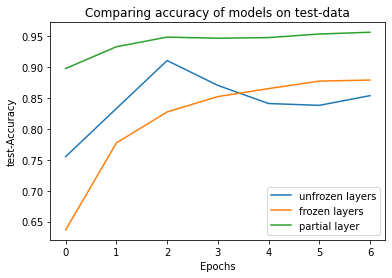

In [30]:
x = results_unfrozen['test_acc']
x_ = results_frozen['test_acc']
xp = results_partial['test_acc']
A = plt.plot(y, x, label = 'unfrozen layer')
B = plt.plot(y, x_, label = 'frozen layer')
B = plt.plot(y, xp, label = 'partial layer')
plt.xlabel("Epochs")
plt.ylabel("test-Accuracy")
plt.title('Comparing accuracy of models on test-data')
plt.legend(['unfrozen layers','frozen layers', 'partial layer'])
plt.show()  

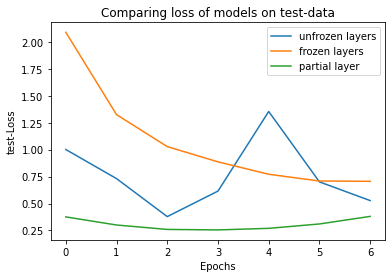

In [32]:
x = results_unfrozen['test_loss']
x_ = results_frozen['test_loss']
xp = results_partial['test_loss']
A = plt.plot(y, x, label = 'unfrozen layer')
B = plt.plot(y, x_, label = 'frozen layer')
B = plt.plot(y, xp, label = 'partial layer')
plt.xlabel("Epochs")
plt.ylabel("test-Loss")
plt.title('Comparing loss of models on test-data')
plt.legend(['unfrozen layers','frozen layers', 'partial layer'])
plt.show() 

#### Accuracy:
The graphs demonstrate that we have better accuracy and lower loss when we freeze the pretrained layers before training the model. Based on the trend, freezing the pretrained layers seem to improve the chance of the model converging as well.

#### Time:
We can see using tqdm.auto, that the training time when we freeze the layers is 08:16 minutes while when we train a model without freezing the layers, the model takes 12:55 minutes to complete 7 epochs. When we freeze the last few layers, our model is only slightly slower, at 08:55, however, the increase to accuracy is worth significant. Thus, freezing the last few pretrained layers gives us better results and is faster.

### Notes on SOTA:

The current state-of-the-art (SOTA) on this dataset has an error rate of 0.37%. As the dataset is relatively small, it is correct to apply transfer learning methods on it.

It is to be noted that since the classes are fairly unbalanced, the data might react positively to normalization techniques, and hyperparameter tuning.